# Lateral isotropic biharmonic Smagorinsky viscosity

In [1]:
import numpy as np
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math
# import matplotlib.colors as colors
# import xarray as xr
# import netCDF4 as nc
# from tqdm import tqdm_notebook
# from mpl_toolkits.basemap import Basemap
# from calendar import month_abbr
import cmocean as cm

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

netcdf_index loaded.


/home/156/aek156/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
# cc.build_index()

In [3]:
figdir = ''
# NOSYNC = '/g/data/v45/aek156/figures/ACCESS-OM2-1-025-010deg-report/figures/ice_validation/NOSYNC/' # where to save figs we don't want to sync
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
#     plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [4]:
# location coords: [ minlon, maxlon, minlat, maxlat ]
# key names are used as filenames so should not have spaces
locations = { 
#               'global': [-80,280,]
              'EACACCSouthPacific': [140-360,240-360,-65,-20], 
              'EACACC':             [140-360,190-360,-65,-20],
              'EAC':                     [145-360,175-360,-45,-20],
              'Kuroshio':                [125-360,155-360,25,50],
              'GulfStream':             [-85,-50,25,50],
              'Agulhas':                 [10,40,-45,-20]
    # TODO: ACC
}

In [5]:
use_cache = True

In [6]:
# load model speed climatologies and snapshots
fields = copy.deepcopy(exptdata.exptdict)  # this will store viscosity fields under the same keys as exptdata.exptdict
for ekey in fields.keys():
#     if ekey == '01deg':
        expt = fields[ekey]['expt']
#         n_files = fields[ekey]['n_files']
        n_files = None
        time_units = fields[ekey]['time_units']
        offset = fields[ekey]['offset']
#         print(ekey, n_files)

        tmp = cc.get_nc_variable(expt, 'ocean.nc', 'aiso_bih',n=n_files,
                                 time_units=time_units, offset=offset, 
                                 use_cache=use_cache).sel(time=slice(tstart,tend))
        aiso_bih = tmp.isel(st_ocean=0).mean('time')
        
        # use actual data start and end since this may differ from tstart, tend
        tstart_data = tmp['time'].data[0]  # first time in model data
        tend_data = tmp['time'].data[-1]  # final time in model data
        fields[ekey]['firstyear'] = pd.to_datetime(tstart_data).year  # not necessarily a full year
        fields[ekey]['lastyear'] = pd.to_datetime(tend_data).year  # not necessarily a full year
        fields[ekey]['yearrange'] = str(fields[ekey]['firstyear']) + '-' + str(fields[ekey]['lastyear'])   # not necessarily full years

        fields[ekey]['aiso_bih'] = aiso_bih
        
        lat = aiso_bih.yu_ocean
        # as used in MOM: https://github.com/mom-ocean/MOM5/blob/99168b44ab45f4f5b4fa2544a0c3f644f0afb666/src/shared/constants/constants.F90#L28
        rEarth = 6371.0e3 
        omega = 7.292e-5
        beta = 2*omega/rEarth*np.cos(np.deg2rad(lat))
        fields[ekey]['WBCscale'] = (aiso_bih/beta)**(1/5) # appendix B of HaidvogelETAL92a
        
        del(tmp, aiso_bih)

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ValueError: No variable aiso_bih found for 1deg_jra55v13_iaf_spinup1_A in ocean.nc

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


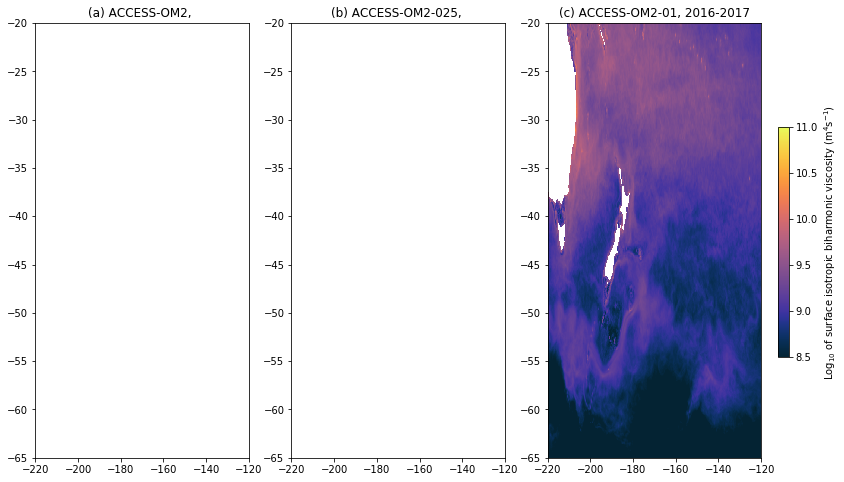

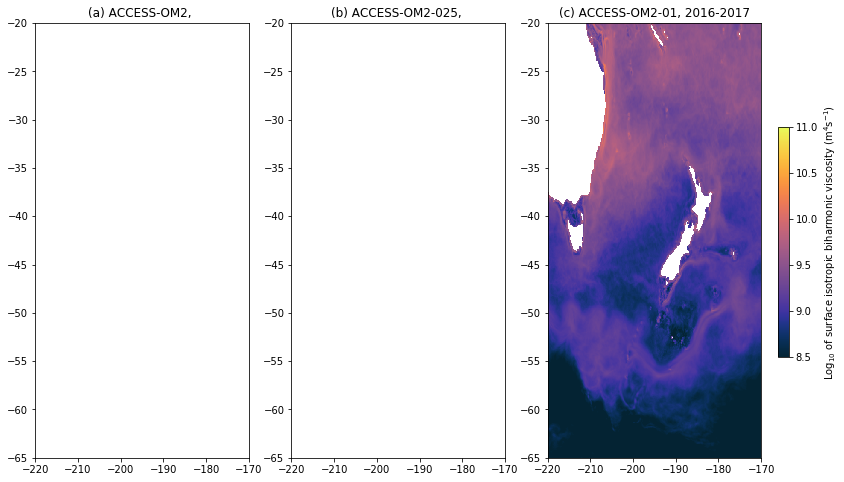

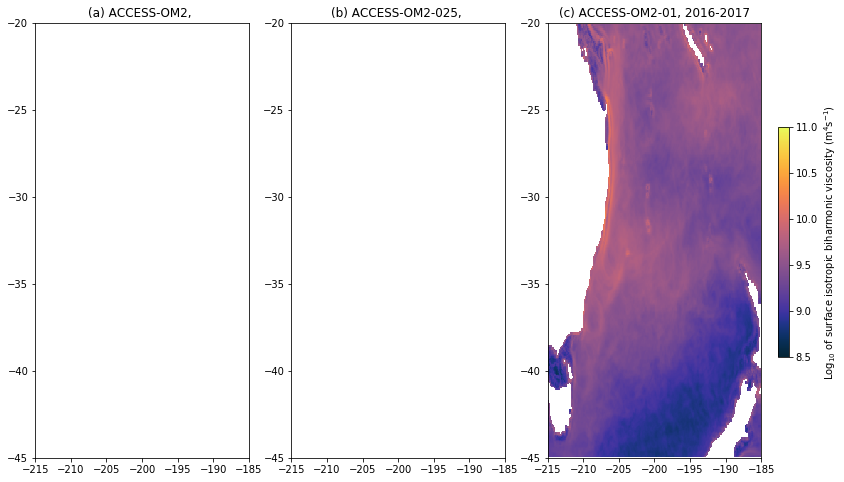

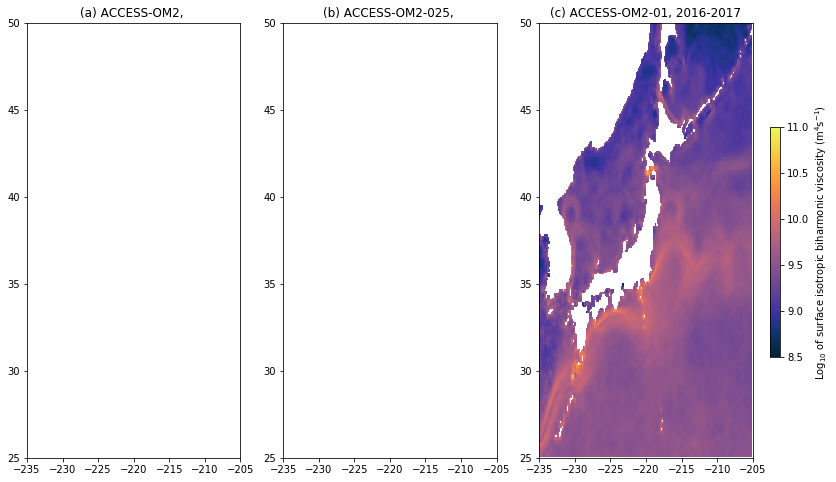

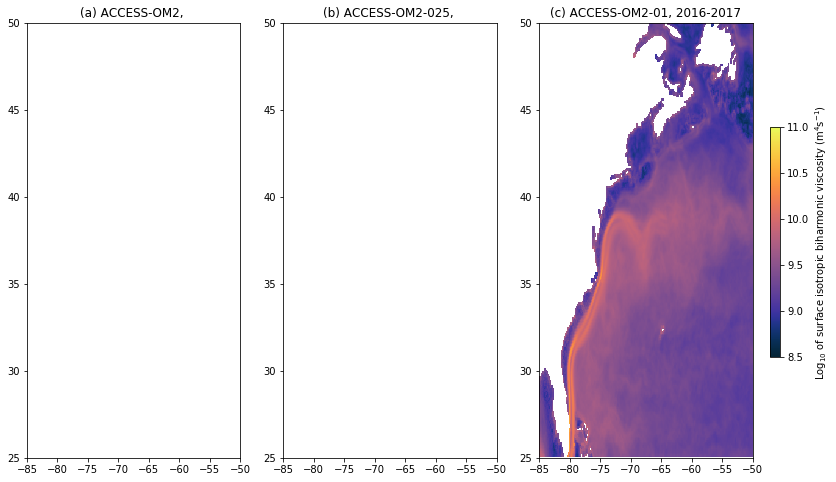

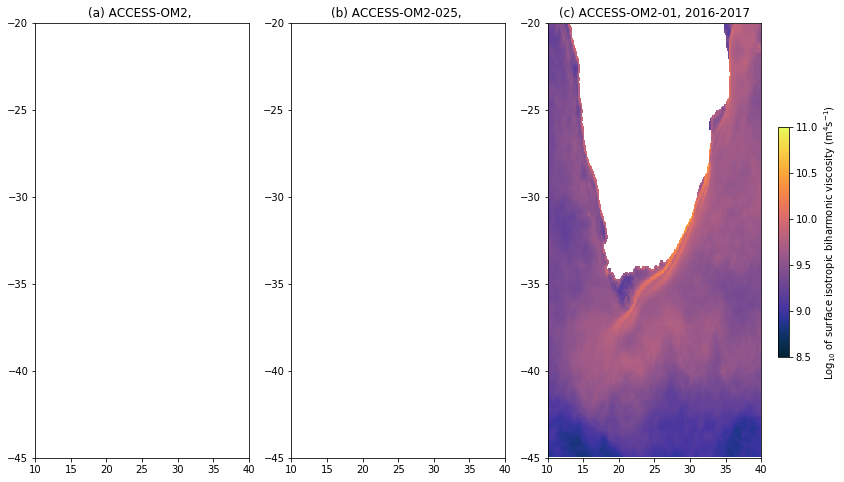

In [12]:
# all model mean fields in each location
nrows = 1
ncols = math.ceil(len(fields)/nrows)
for locname,loc in locations.items():
    fig = plt.figure(figsize=(12,8))
    for i, ekey in enumerate(fields.keys()):
        ax = fig.add_subplot(nrows, ncols, i+1)
        yearrange = '' # default, overridden if data exists 
        if ekey == '01deg':
            yearrange = fields[ekey]['yearrange']
            aiso_bih = fields[ekey]['aiso_bih'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))
            cax = ax.pcolormesh(aiso_bih.xu_ocean, aiso_bih.yu_ocean, np.log10(aiso_bih), 
                                shading='flat', cmap=cm.cm.thermal, vmin=8.5, vmax=11)
        plt.title('(' + chr(ord('a')+i) + ') ' + fields[ekey]['desc'] + ', ' + yearrange)
        plt.xlim(loc[0],loc[1])
        plt.ylim(loc[2],loc[3])
    
    plt.subplots_adjust(left=0.08,right=0.92)
    ax1 = plt.axes([0.94,0.3,0.012,0.4])
    cb = plt.colorbar(cax,cax=ax1,orientation='vertical') #,extend='max')
    cb.ax.set_ylabel(r'Log$_{10}$ of surface isotropic biharmonic viscosity (m$^4$s$^{-1}$)')
    savefigure('viscosity_'+locname+'_clim')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


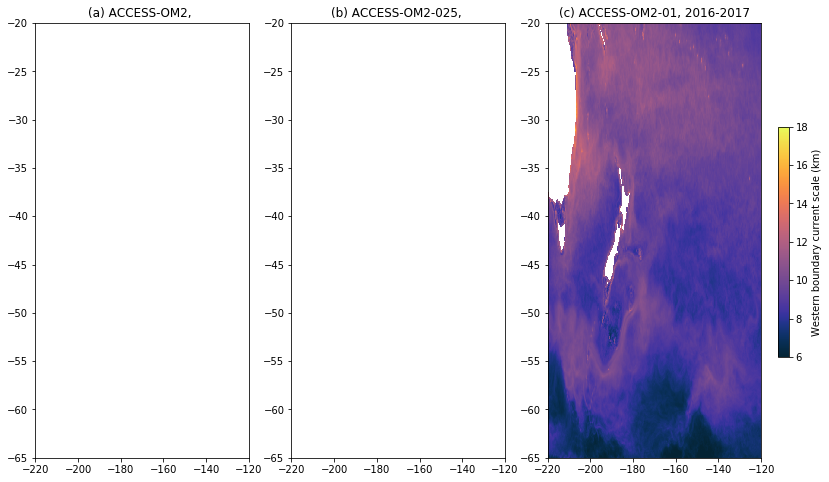

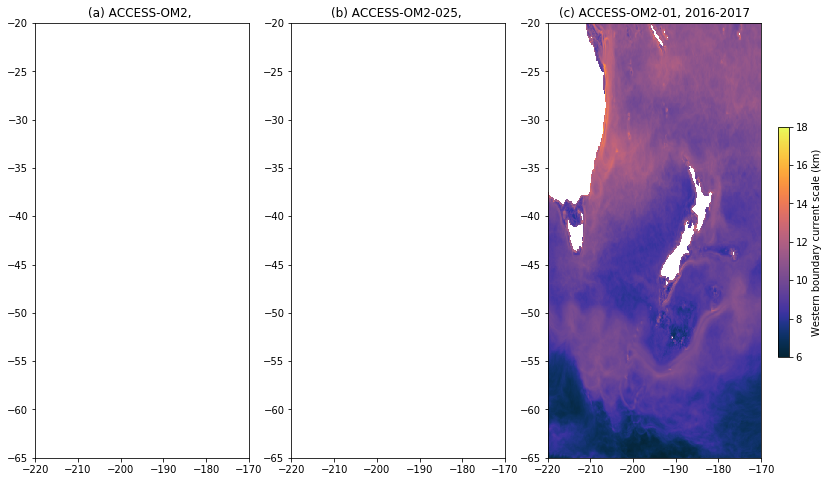

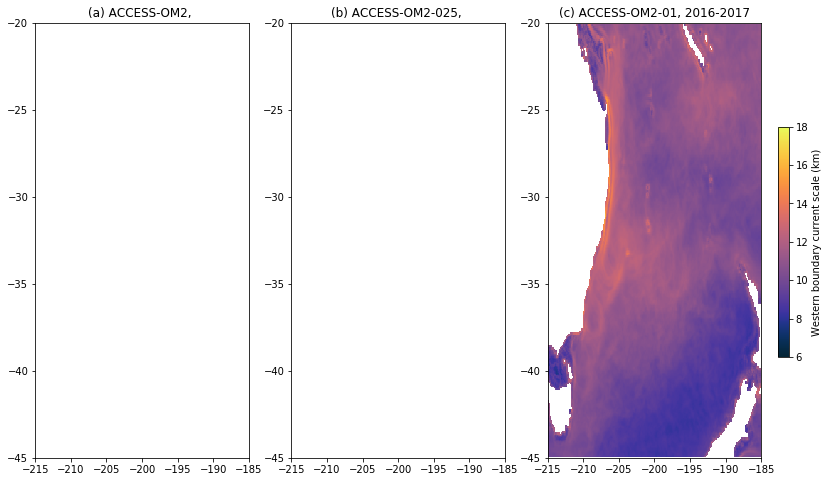

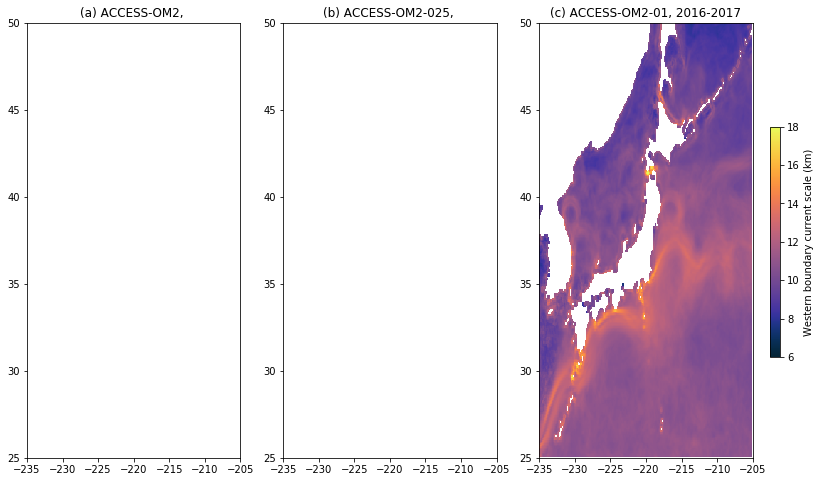

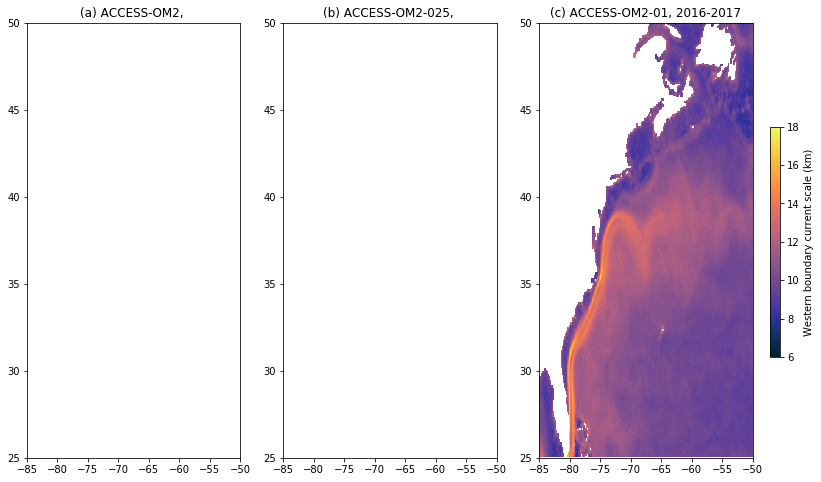

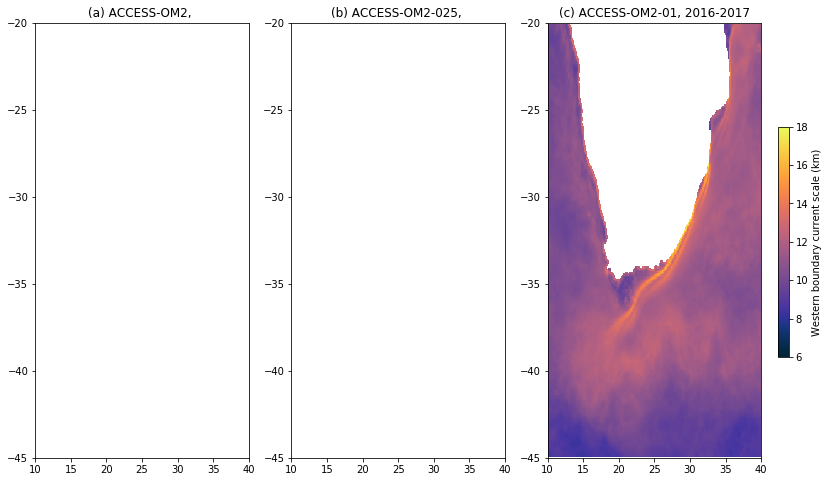

In [13]:
# all model mean fields in each location
nrows = 1
ncols = math.ceil(len(fields)/nrows)
for locname,loc in locations.items():
    fig = plt.figure(figsize=(12,8))
    for i, ekey in enumerate(fields.keys()):
        ax = fig.add_subplot(nrows, ncols, i+1)
        yearrange = '' # default, overridden if data exists 
        if ekey == '01deg':
            yearrange = fields[ekey]['yearrange']
            WBCscale = fields[ekey]['WBCscale'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))
            cax = ax.pcolormesh(WBCscale.xu_ocean, WBCscale.yu_ocean, WBCscale/1000, 
                                shading='flat', cmap=cm.cm.thermal, vmin=6, vmax=18)
        plt.title('(' + chr(ord('a')+i) + ') ' + fields[ekey]['desc'] + ', ' + yearrange)
        plt.xlim(loc[0],loc[1])
        plt.ylim(loc[2],loc[3])
     
    plt.subplots_adjust(left=0.08,right=0.92)
    ax1 = plt.axes([0.94,0.3,0.012,0.4])
    cb = plt.colorbar(cax,cax=ax1,orientation='vertical') #,extend='max')
    cb.ax.set_ylabel(r'Western boundary current scale (km)')
    savefigure('WBCscale_'+locname+'_clim')